
### Please make an explorative data analysis and build a prediction model for the hourly utilization “cnt” 


In [47]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.externals import joblib
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
address = 'datasets/hour.csv'
df = pd.read_csv(address)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [6]:
df['datetime'] = pd.to_datetime(df['dteday'], format="%Y-%m-%d")
#df['datetime_utc'] = pd.to_datetime(df['datetime'], utc='True')

df = df.set_index('datetime')

#df.index = df.index.tz_convert(None)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
datetime,,,,,,,,,,,,,,,,,
2011-01-01,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [17]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [22]:
corr_matrix = df.corr()
corr_matrix["yr"].sort_values(ascending=False)

yr            1.000000
instant       0.866014
registered    0.253684
cnt           0.250495
casual        0.142779
temp          0.040913
atemp         0.039222
holiday       0.006692
workingday   -0.002196
hr           -0.003867
weekday      -0.004485
windspeed    -0.008740
mnth         -0.010473
season       -0.010742
weathersit   -0.019157
hum          -0.083546
Name: yr, dtype: float64

In [10]:
df_2011 = df.loc['2011-01-01':'2011-12-31']
df_2012 = df.loc['2012-01-01':'2012-12-31']
df_2011_1000 = df_2011.sample(n=1000,random_state=25, axis=0)
df_2012_1000 = df_2012.sample(n=1000,random_state=25, axis=0)


In [12]:
df_2011["cnt"].mean()

143.79444765760556

In [13]:
df_2011["cnt"].median()

109.0

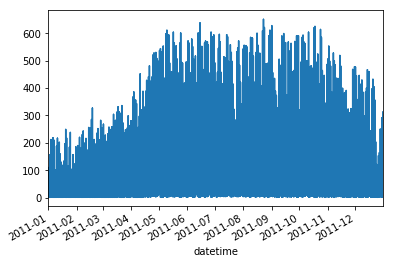

In [11]:
df_2011["cnt"].plot()

In [14]:
df_2012["cnt"].mean()

234.6663613464621

In [15]:
df_2012["cnt"].median()

191.0

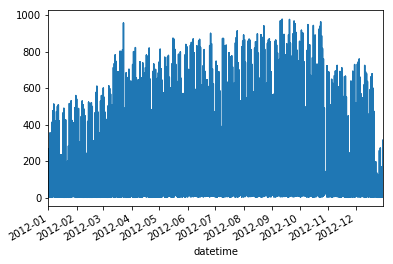

In [16]:
df_2012["cnt"].plot()

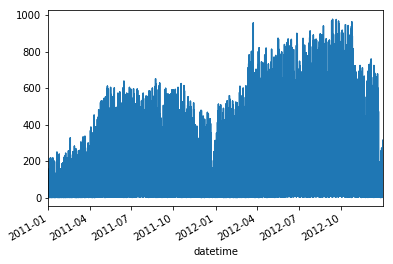

In [8]:
df["cnt"].plot()

In [23]:
address = 'datasets/hour.csv'
data = pd.read_csv(address)

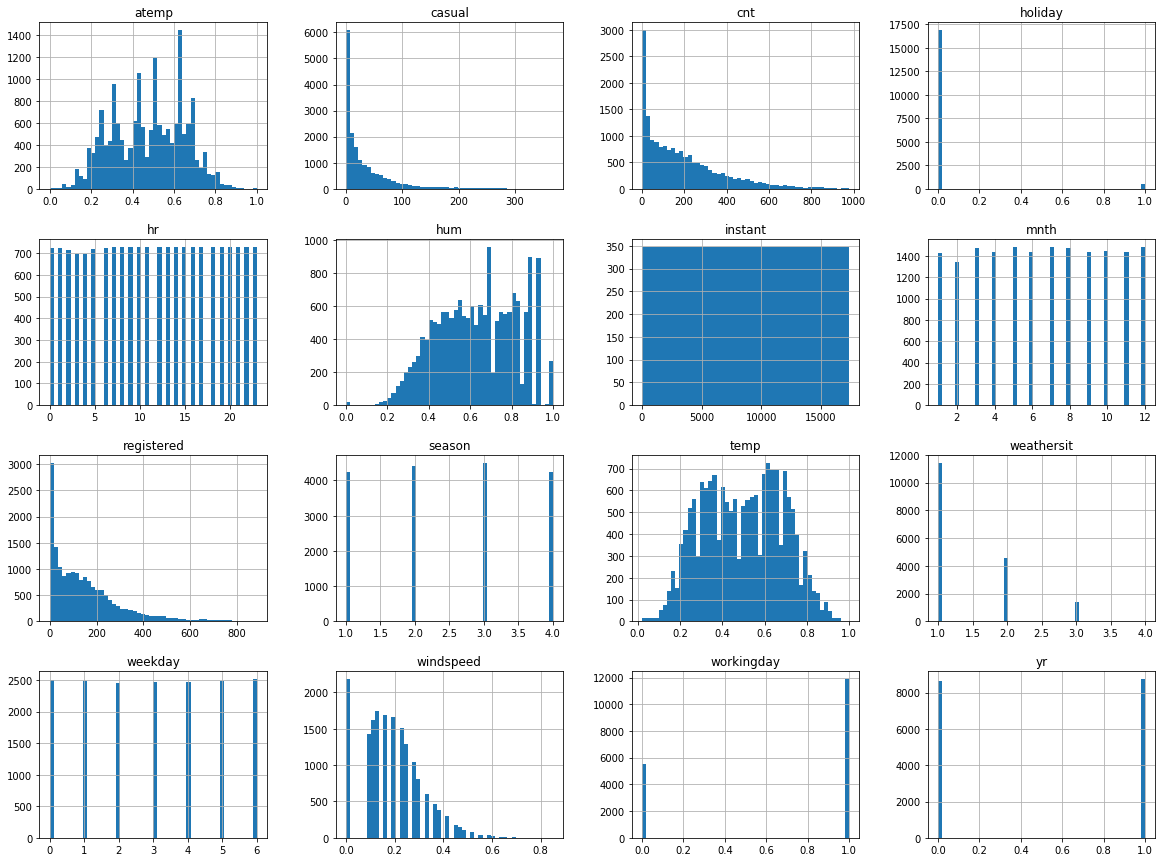

In [52]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [69]:
corr_matrix = data.corr()
corr_matrix["cnt"].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

In [70]:
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1,0.4,0.87,0.49,-0.0048,0.015,0.0014,-0.0034,-0.014,0.14,0.14,0.0096,-0.075,0.16,0.28,0.28
season,0.4,1,-0.011,0.83,-0.0061,-0.0096,-0.0023,0.014,-0.015,0.31,0.32,0.15,-0.15,0.12,0.17,0.18
yr,0.87,-0.011,1,-0.01,-0.0039,0.0067,-0.0045,-0.0022,-0.019,0.041,0.039,-0.084,-0.0087,0.14,0.25,0.25
mnth,0.49,0.83,-0.01,1,-0.0058,0.018,0.01,-0.0035,0.0054,0.2,0.21,0.16,-0.14,0.068,0.12,0.12
hr,-0.0048,-0.0061,-0.0039,-0.0058,1,0.00048,-0.0035,0.0023,-0.02,0.14,0.13,-0.28,0.14,0.3,0.37,0.39
holiday,0.015,-0.0096,0.0067,0.018,0.00048,1,-0.1,-0.25,-0.017,-0.027,-0.031,-0.011,0.004,0.032,-0.047,-0.031
weekday,0.0014,-0.0023,-0.0045,0.01,-0.0035,-0.1,1,0.036,0.0033,-0.0018,-0.0088,-0.037,0.012,0.033,0.022,0.027
workingday,-0.0034,0.014,-0.0022,-0.0035,0.0023,-0.25,0.036,1,0.045,0.055,0.055,0.016,-0.012,-0.3,0.13,0.03
weathersit,-0.014,-0.015,-0.019,0.0054,-0.02,-0.017,0.0033,0.045,1,-0.1,-0.11,0.42,0.026,-0.15,-0.12,-0.14
temp,0.14,0.31,0.041,0.2,0.14,-0.027,-0.0018,0.055,-0.1,1,0.99,-0.07,-0.023,0.46,0.34,0.4


In [71]:
X = data.drop(['instant'], axis=1)
X = X.drop(['dteday'], axis=1)
X = X.drop(['yr'], axis=1)
X = X.drop(['temp'], axis=1)
X = X.drop(['cnt'], axis=1)

y =data['cnt'].values 

In [54]:
from sklearn.metrics import mean_squared_error
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [73]:
y_test

array([  7,   5, 743, ..., 499, 302, 229])

In [74]:
# Fit regression model
model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    min_samples_leaf=9,
    max_features=0.1,
    loss='huber'
)

In [75]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=6,
             max_features=0.1, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=9, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [76]:
joblib.dump(model, 'trained_bike_BDT_regresion_model.pkl')

['trained_bike_BDT_regresion_model.pkl']

In [77]:
error_rmse = rmse(y_train, model.predict(X_train))
print("Training Set Root Mean Square Error: %.4f" % error_rmse)

Training Set Root Mean Square Error: 5.9727


In [78]:
mse = mean_absolute_error(y_train, model.predict(X_train))
print("Training Set Mean Absolute Error: %.4f" % mse)

Training Set Mean Absolute Error: 4.1561


In [79]:
error_rmse_test = rmse(y_test, model.predict(X_test))
print("Test Set Root Mean Square Error: %.4f" % error_rmse_test)

Test Set Root Mean Square Error: 11.1553


In [80]:
mse = mean_absolute_error(y_test, model.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % mse)

Test Set Mean Absolute Error: 7.7748


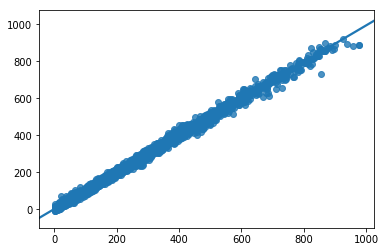

In [81]:
#y_test.loc[:, 'Prediction'] = np.round(model.predict(X_test))
sb.regplot(y_test, np.round(model.predict(X_test)), scatter=True)

In [82]:
feature_labels = np.array(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
                           'atemp', 'hum', 'windspeed', 'casual', 'registered'])

In [83]:
# Load the trained model created with train_model.py
#model = joblib.load('trained_bike_BDT_regresion_model.pkl')

# Create a numpy array based on the model's feature importances
importance = model.feature_importances_

# Sort the feature labels based on the feature importance rankings from the model
feauture_indexes_by_importance = importance.argsort()

# Print each feature label, from most important to least important (reverse order)
for index in feauture_indexes_by_importance:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))

holiday - 0.05%
weekday - 0.30%
workingday - 0.35%
windspeed - 0.43%
weathersit - 0.84%
season - 1.58%
mnth - 2.59%
hum - 3.57%
atemp - 4.71%
casual - 17.45%
hr - 18.43%
registered - 49.68%
